In [7]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.transforms as tfs
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

0 0


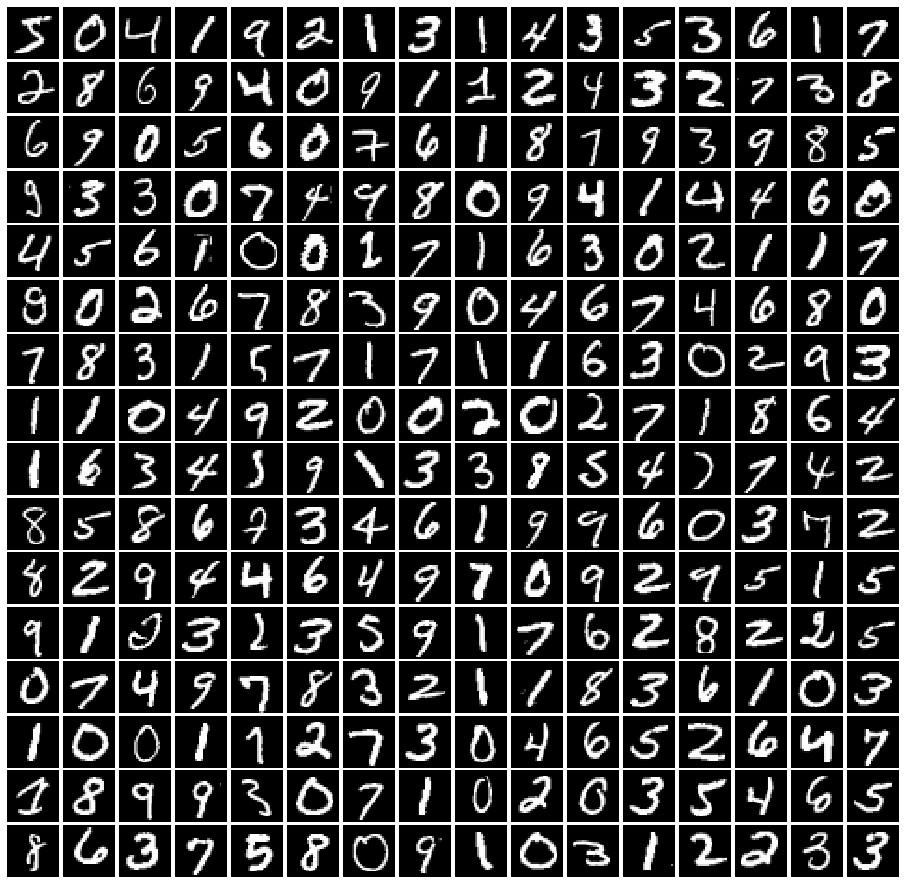

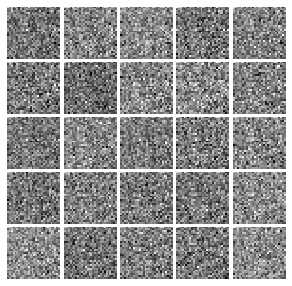


1 250


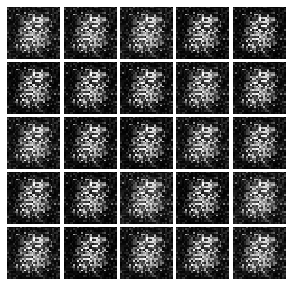


2 500


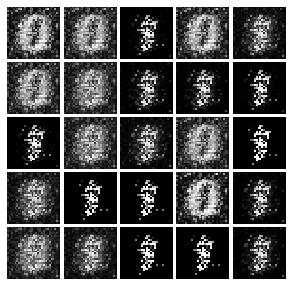


3 750


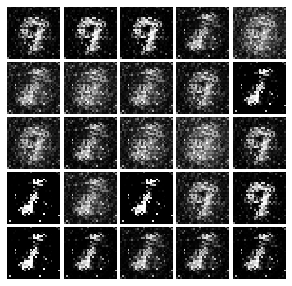


5 1000


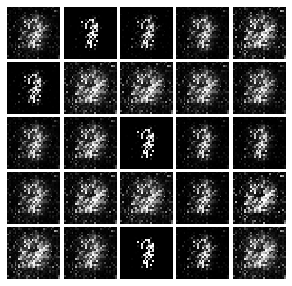


6 1250


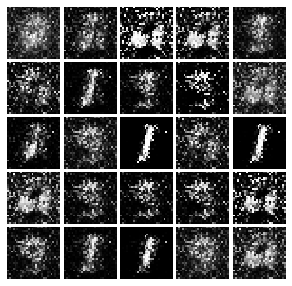


7 1500


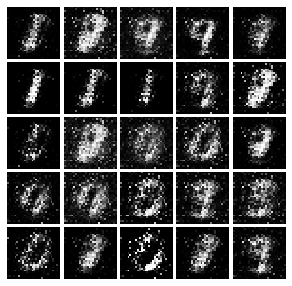


8 1750


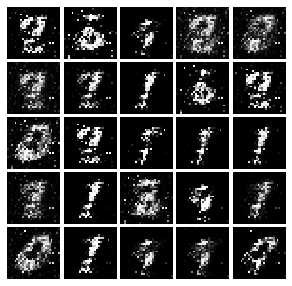


10 2000


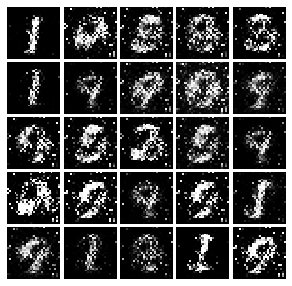


11 2250


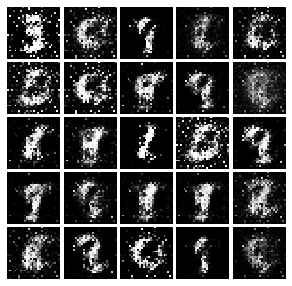


12 2500


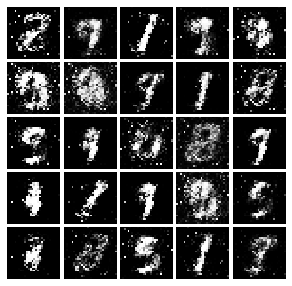


14 2750


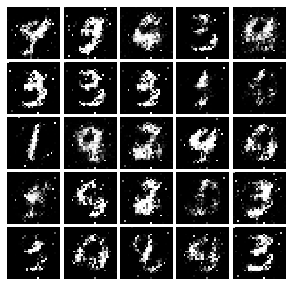


15 3000


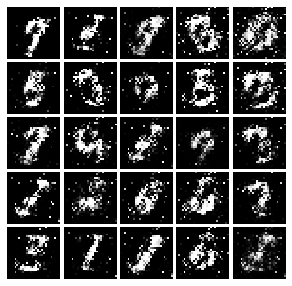


16 3250


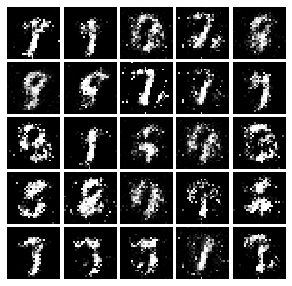


17 3500


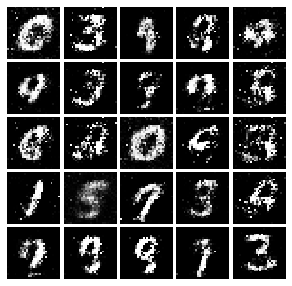


19 3750


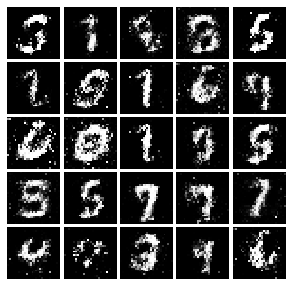


20 4000


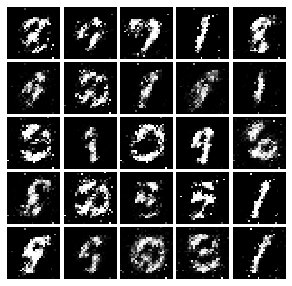


21 4250


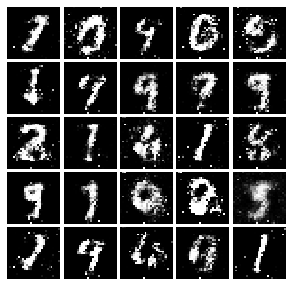


22 4500


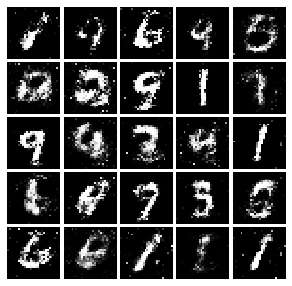


24 4750


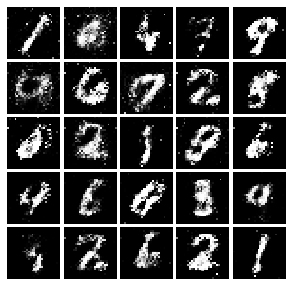


25 5000


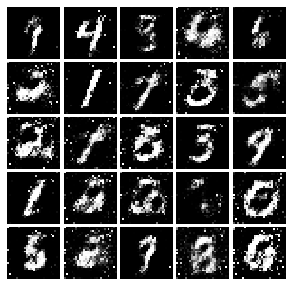


26 5250


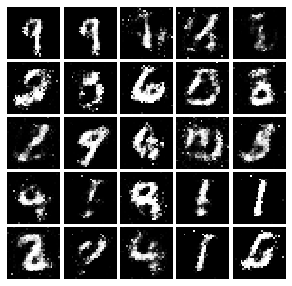


28 5500


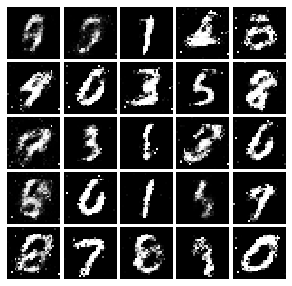


29 5750


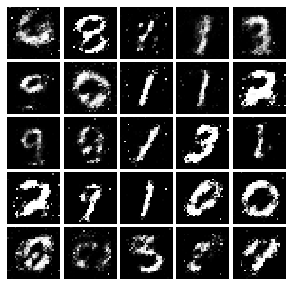


30 6000


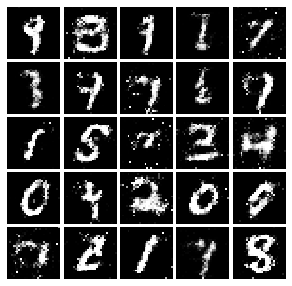


31 6250


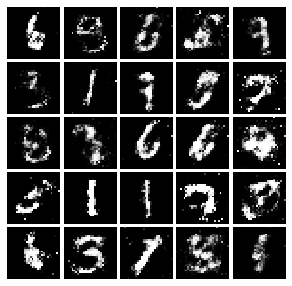


33 6500


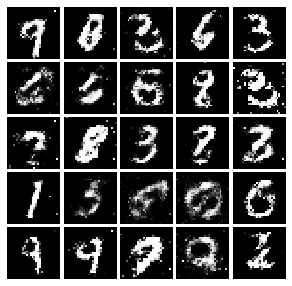


34 6750


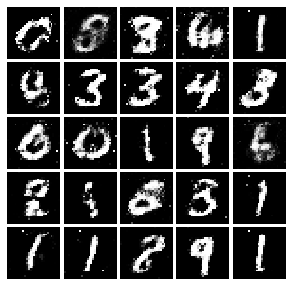


35 7000


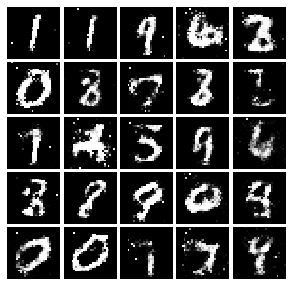


36 7250


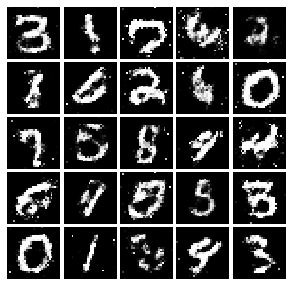


38 7500


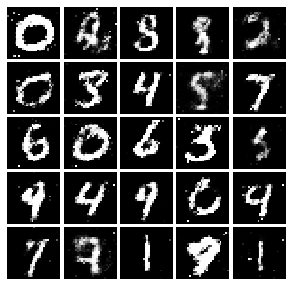


39 7750


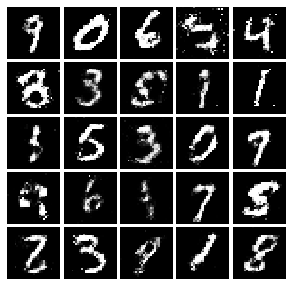


40 8000


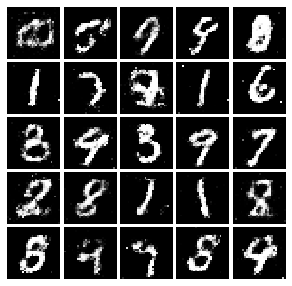


42 8250


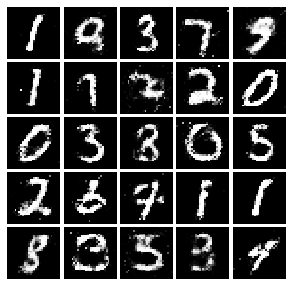


43 8500


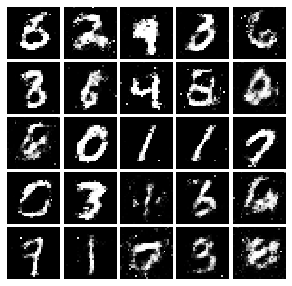


44 8750


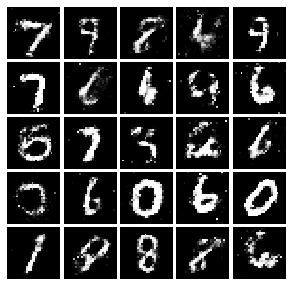


45 9000


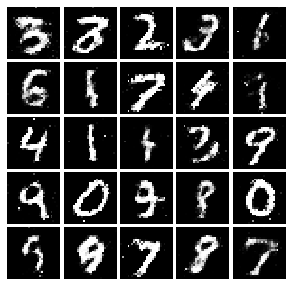


47 9250


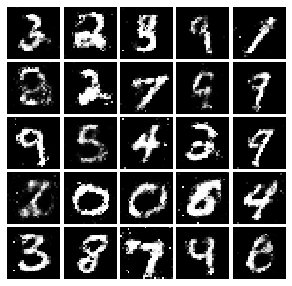


48 9500


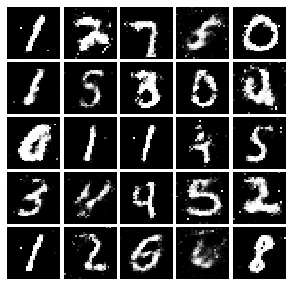


49 9750


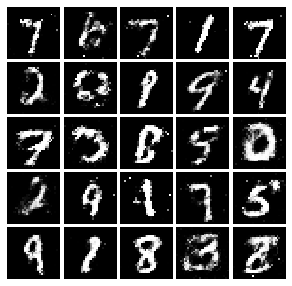


51 10000


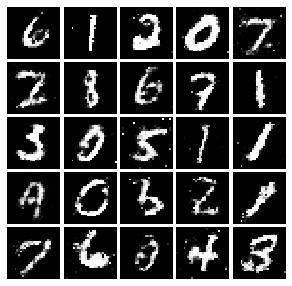


52 10250


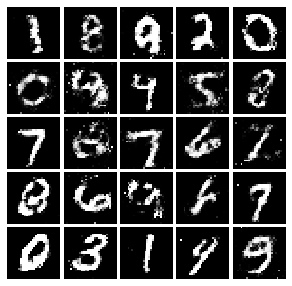


53 10500


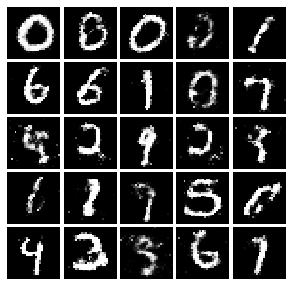


54 10750


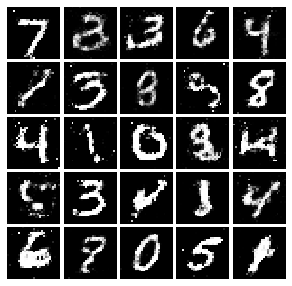


56 11000


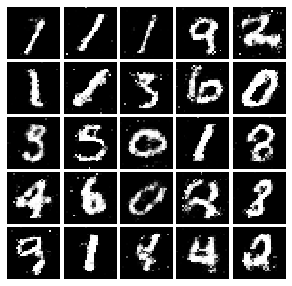


57 11250


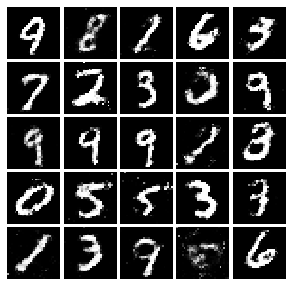


58 11500


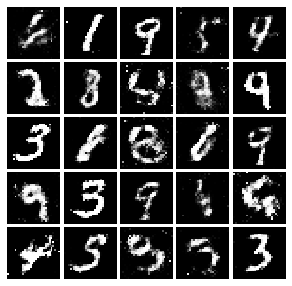


59 11750


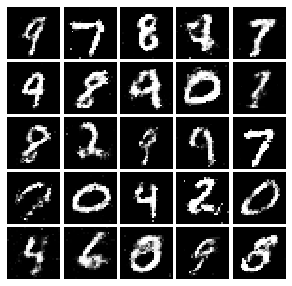


61 12000


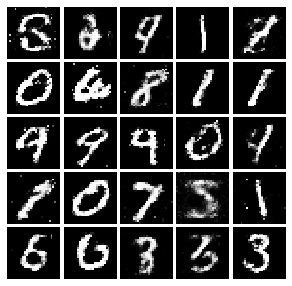


62 12250


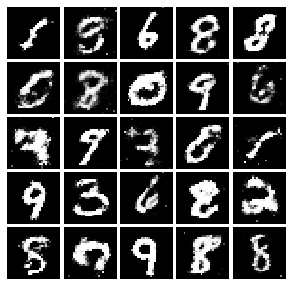


63 12500


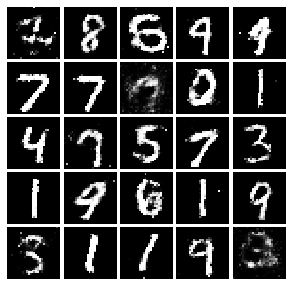


65 12750


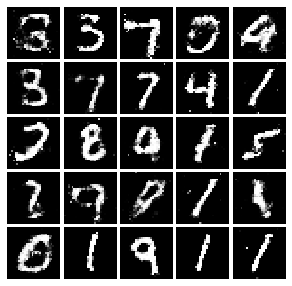


66 13000


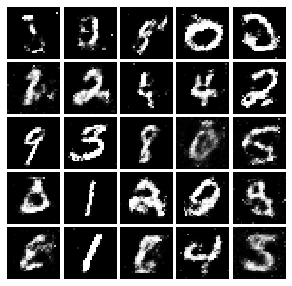


67 13250


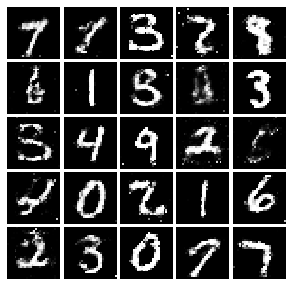


68 13500


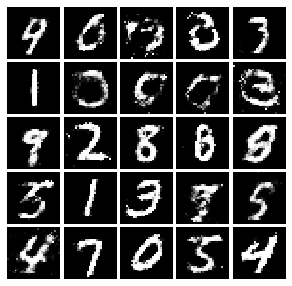


70 13750


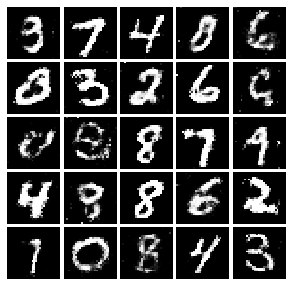


71 14000


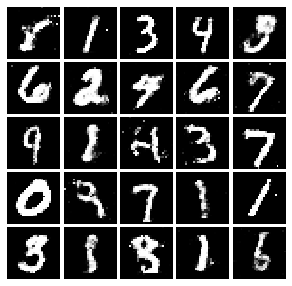


72 14250


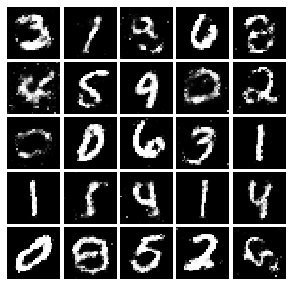


73 14500


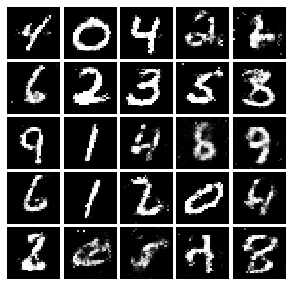


75 14750


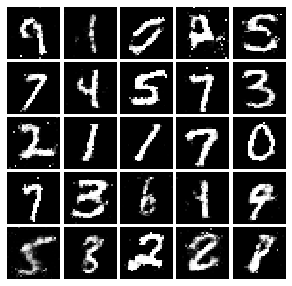


76 15000


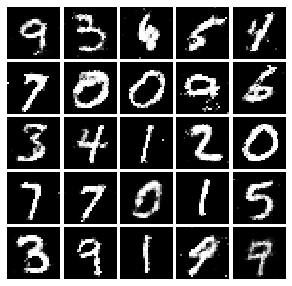


77 15250


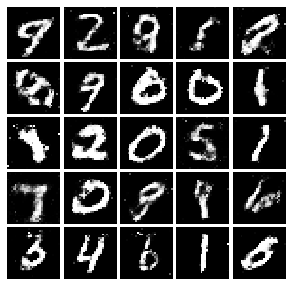


79 15500


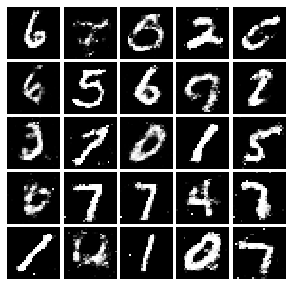


80 15750


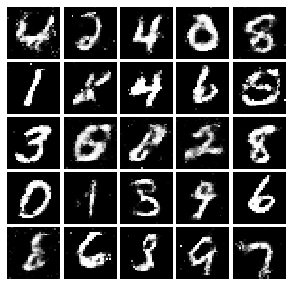


81 16000


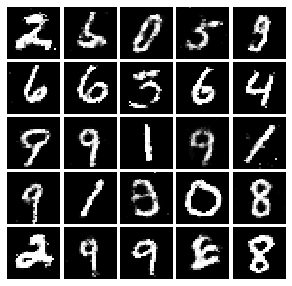


82 16250


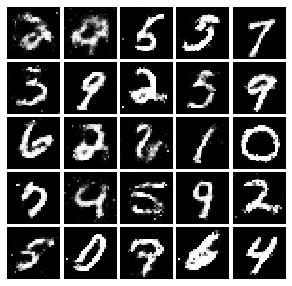


84 16500


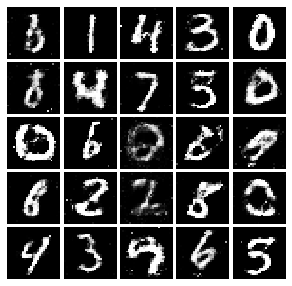


85 16750


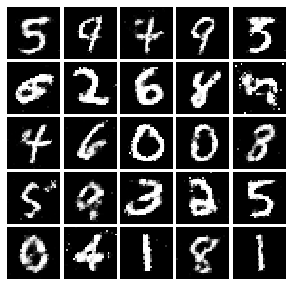


86 17000


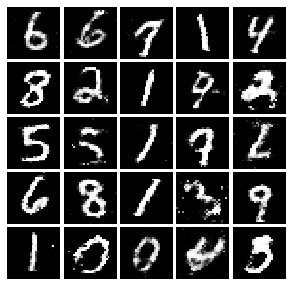


88 17250


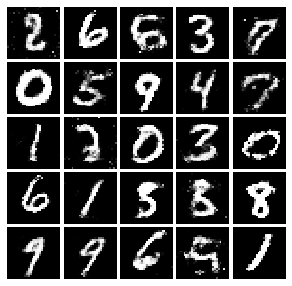


89 17500


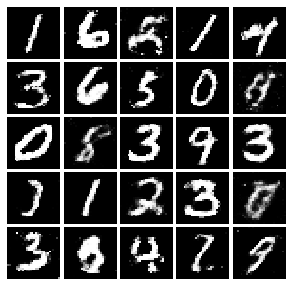


90 17750


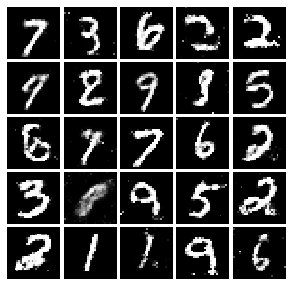


91 18000


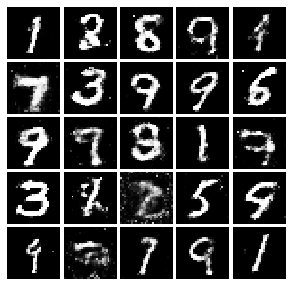


93 18250


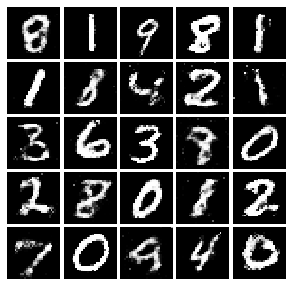


94 18500


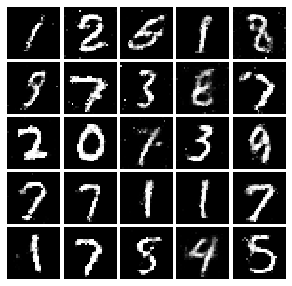


95 18750


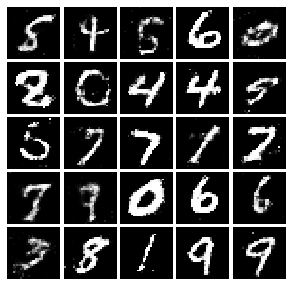


96 19000


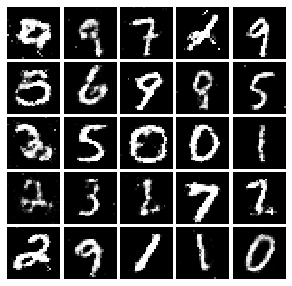


98 19250


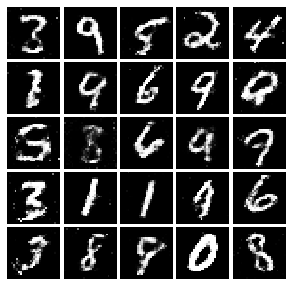


99 19500


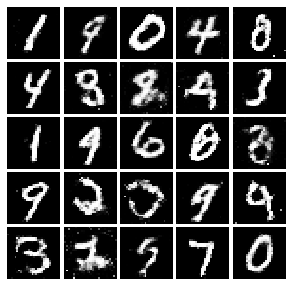


100 19750


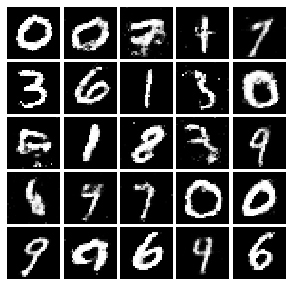


102 20000


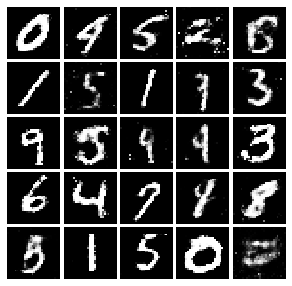


103 20250


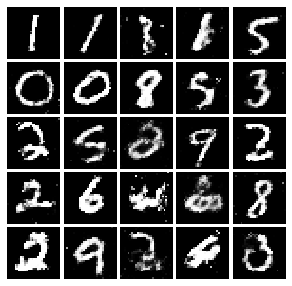


104 20500


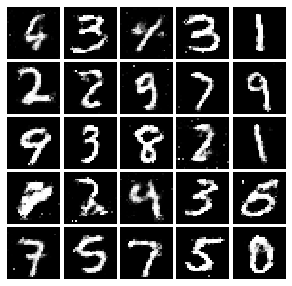


105 20750


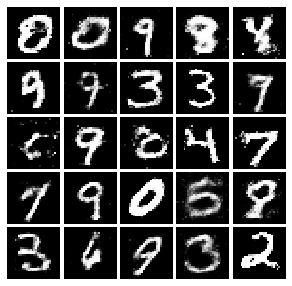


107 21000


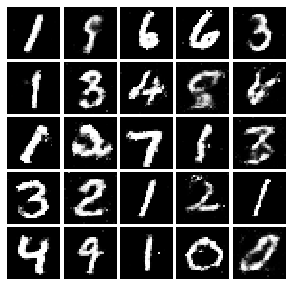


108 21250


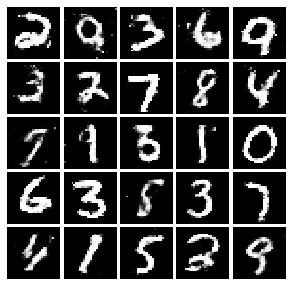


109 21500


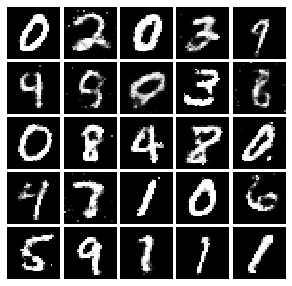


110 21750


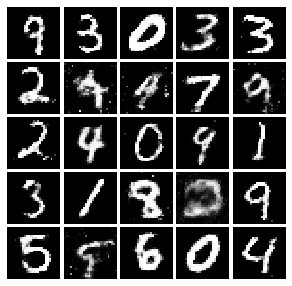


112 22000


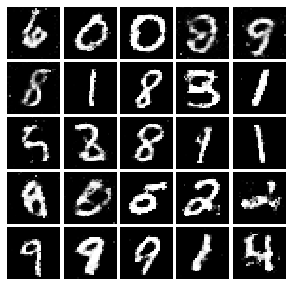


113 22250


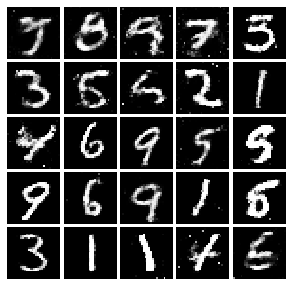


114 22500


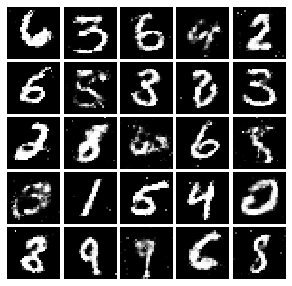


116 22750


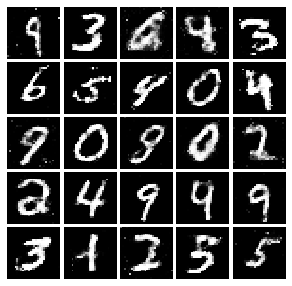


117 23000


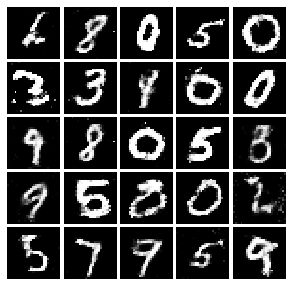


118 23250


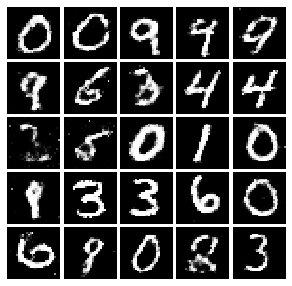


119 23500


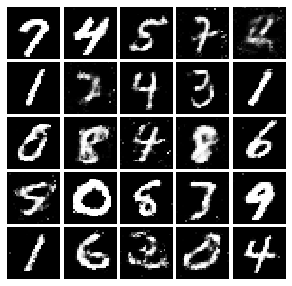


121 23750


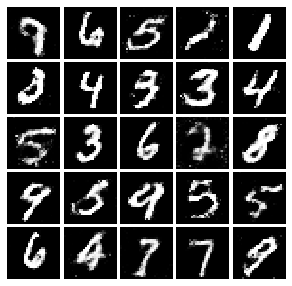


122 24000


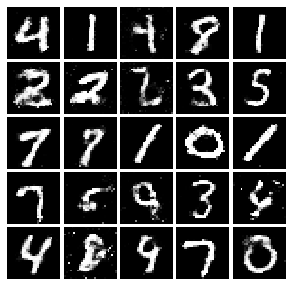


123 24250


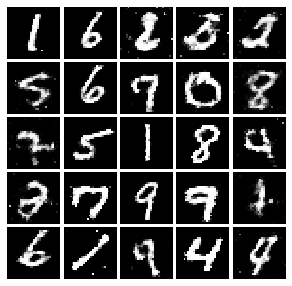


125 24500


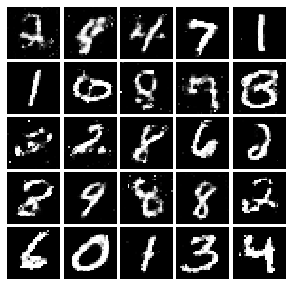


126 24750


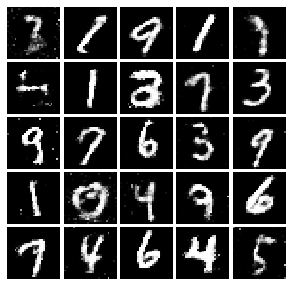


127 25000


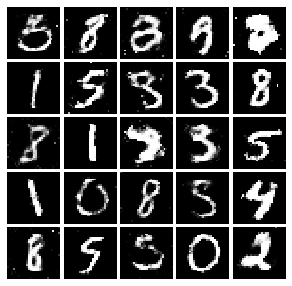


128 25250


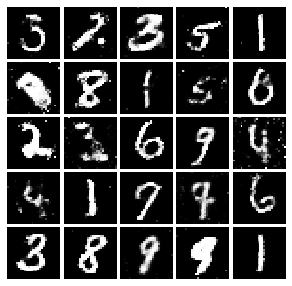


130 25500


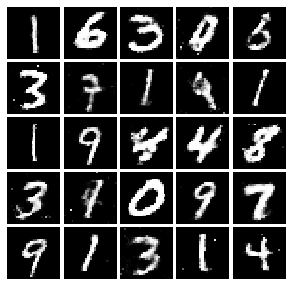


131 25750


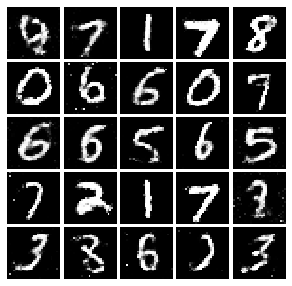


132 26000


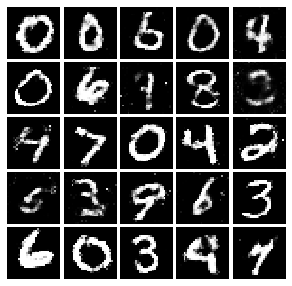


133 26250


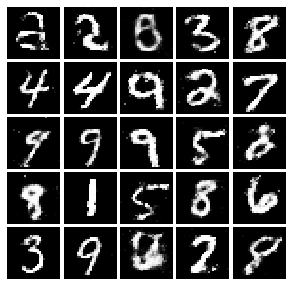


135 26500


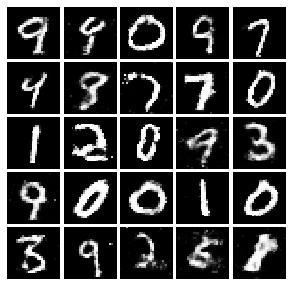


136 26750


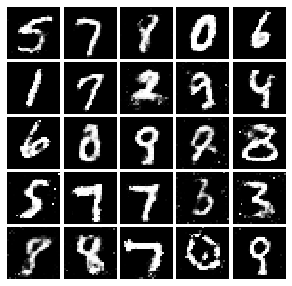


137 27000


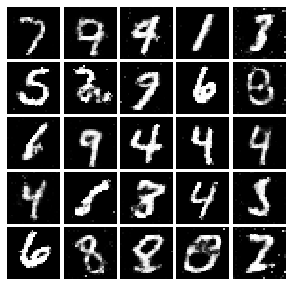


139 27250


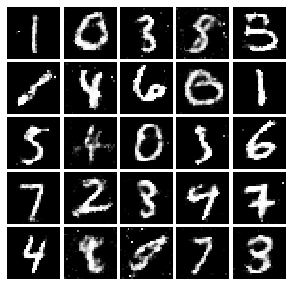


140 27500


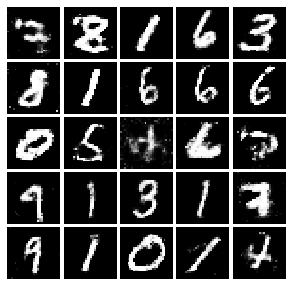


141 27750


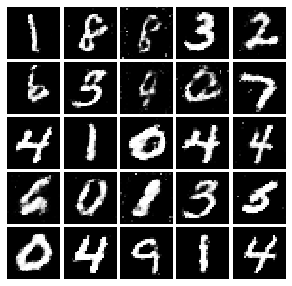


142 28000


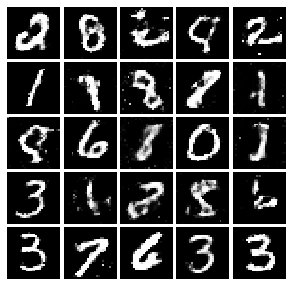


144 28250


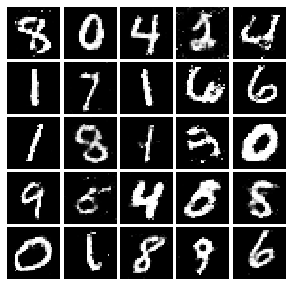


145 28500


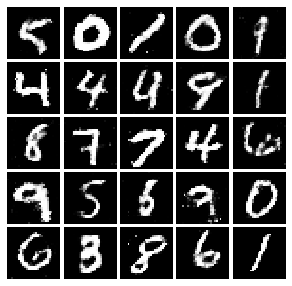


146 28750


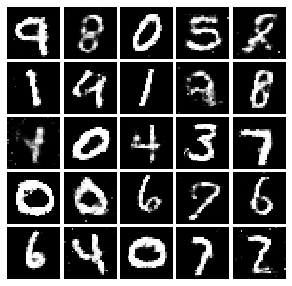


147 29000


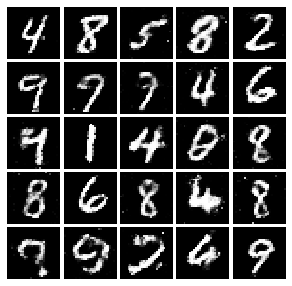


149 29250


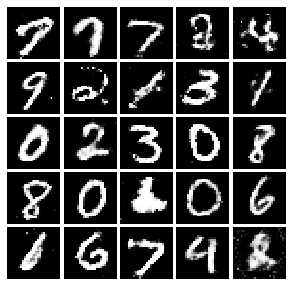


150 29500


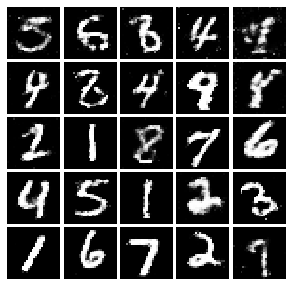


151 29750


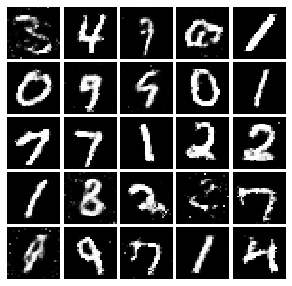


153 30000


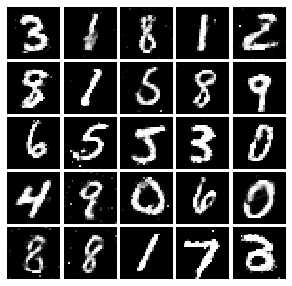


154 30250


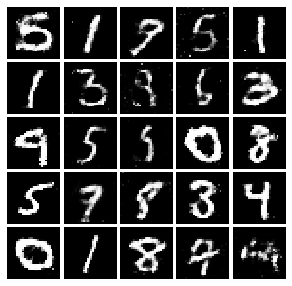


155 30500


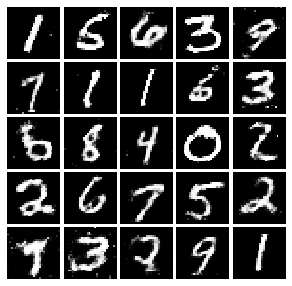


156 30750


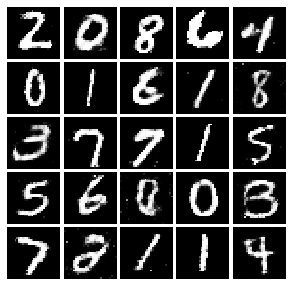


158 31000


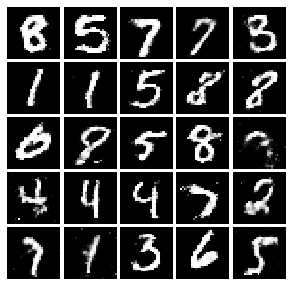


159 31250


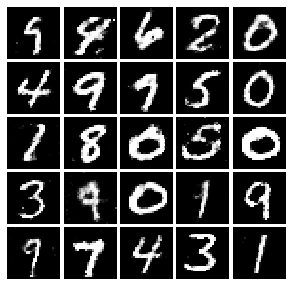


160 31500


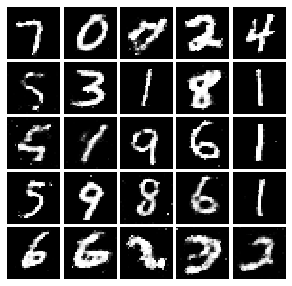


161 31750


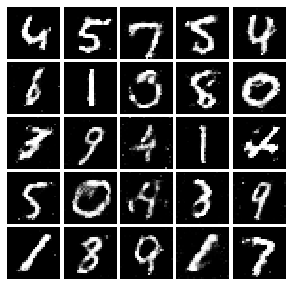


163 32000


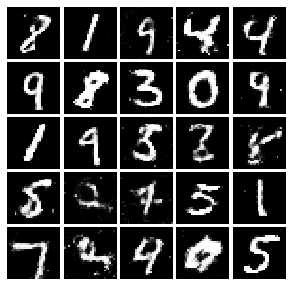


164 32250


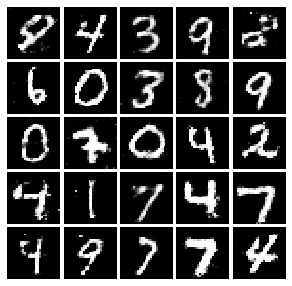


165 32500


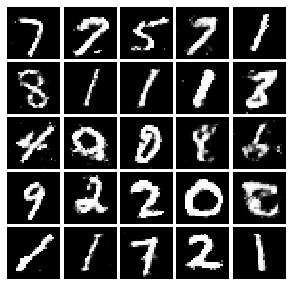


167 32750


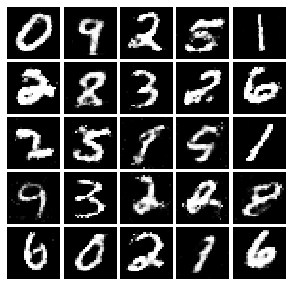


168 33000


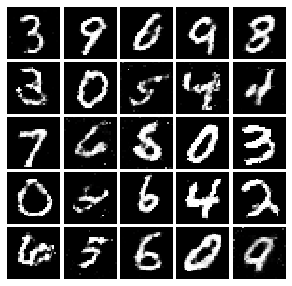


169 33250


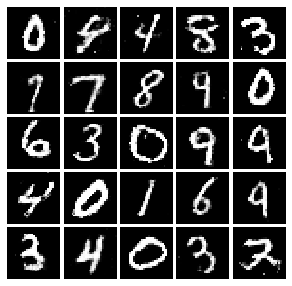


170 33500


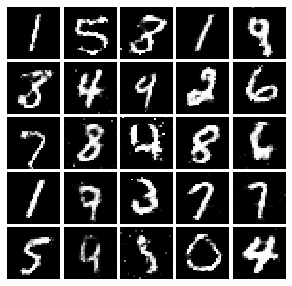


172 33750


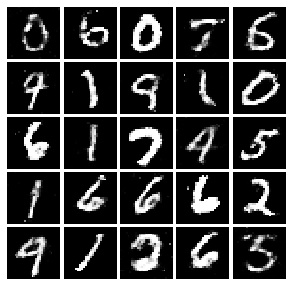


173 34000


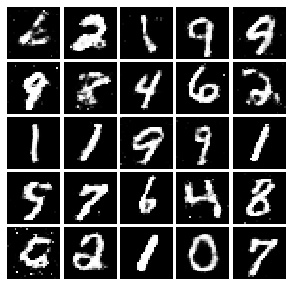


174 34250


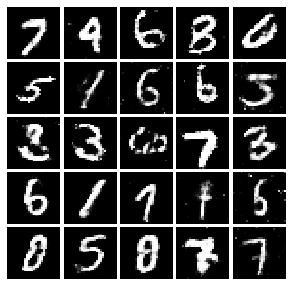


176 34500


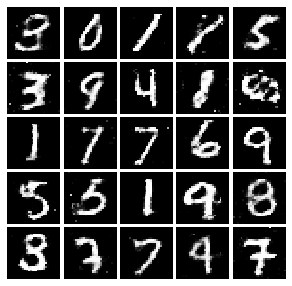


177 34750


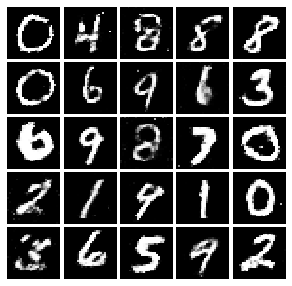


178 35000


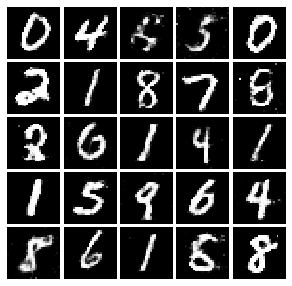


179 35250


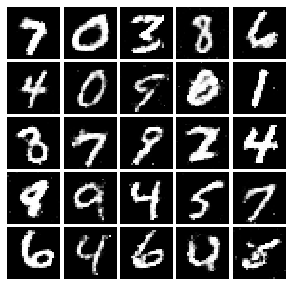


181 35500


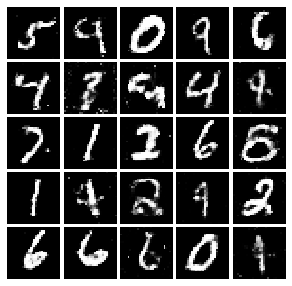


182 35750


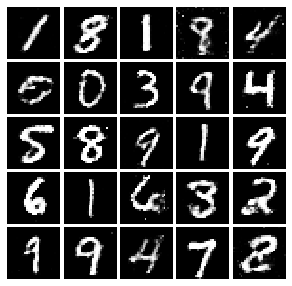


183 36000


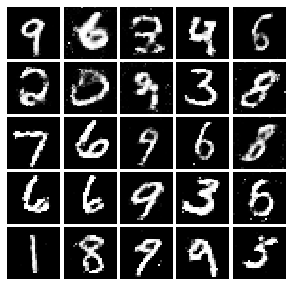


184 36250


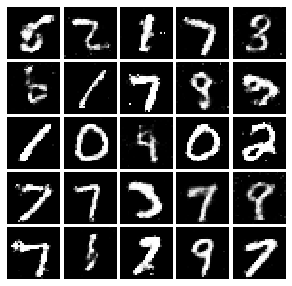


186 36500


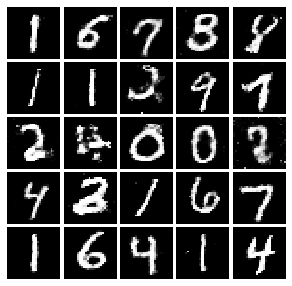


187 36750


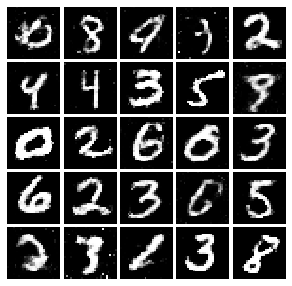


188 37000


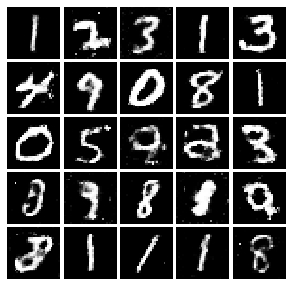


190 37250


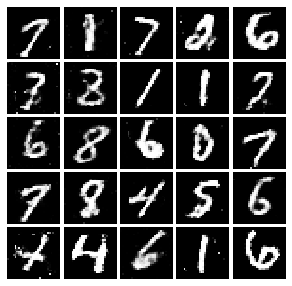


191 37500


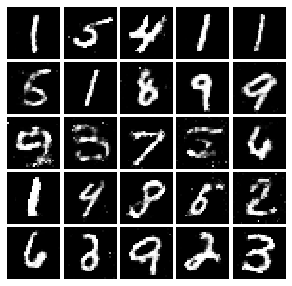


192 37750


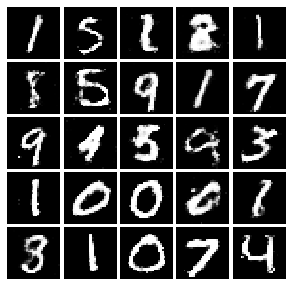


193 38000


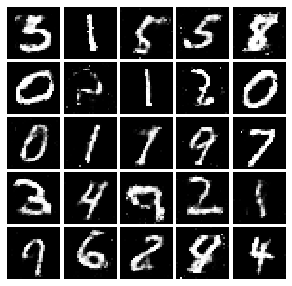


195 38250


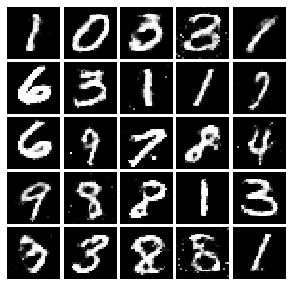


196 38500


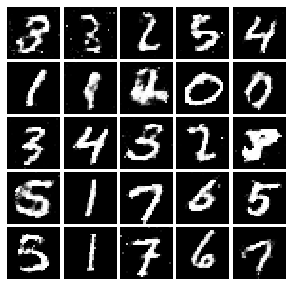


197 38750


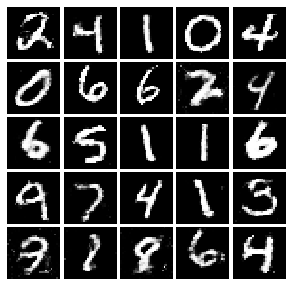


198 39000


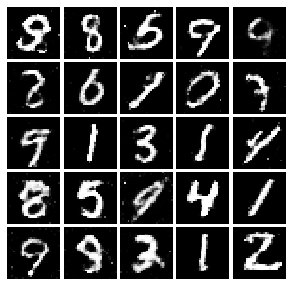


200 39250


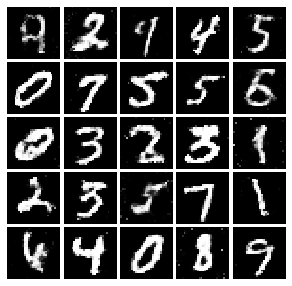


201 39500


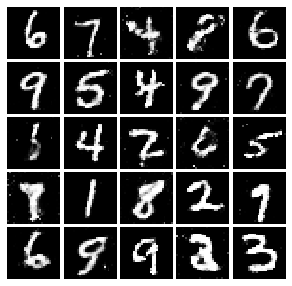


202 39750


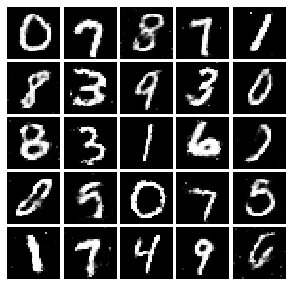


204 40000


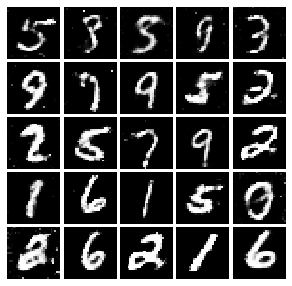


205 40250


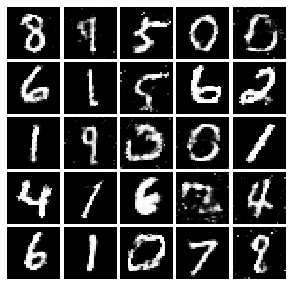


206 40500


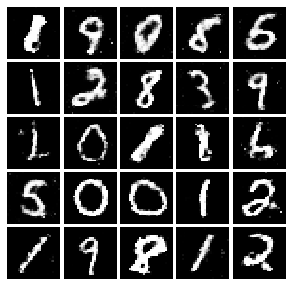


207 40750


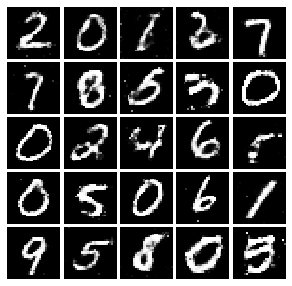


209 41000


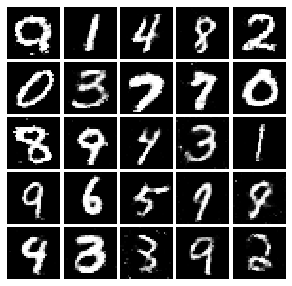

In [27]:
# matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0
class ChunkSampler(sampler.Sampler): # 定义一个取样的函数
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 256

train_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))


imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze() # 可视化图片效果
show_images(imgs)
def discriminator():
    net = nn.Sequential(        
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    return net
def generator(noise_dim=NOISE_DIM):   
    net = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 784),
        nn.Tanh()
    )
    return net
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(logits_real, logits_fake): # 判别器的 loss
    size = logits_real.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    false_labels = Variable(torch.zeros(size, 1)).float().cuda()
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss

def generator_loss(logits_fake): # 生成器的 loss  
    size = logits_fake.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    loss = bce_loss(logits_fake, true_labels)
    return loss

# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

def train(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, 
    generator_loss, show_every=250, noise_size=96, num_epochs=210):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # 判别网络
            real_data = Variable(x).view(bs, -1).cuda() # 真实数据
            logits_real = D_net(real_data) # 判别网络得分
            # -1 ~ 1 的均匀分布
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分
            # 判别器的 loss
            d_total_error = discriminator_loss(logits_real, logits_fake) 
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print(epoch, iter_count)
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:25])
                plt.show()
                print()
            iter_count += 1
            
D = discriminator().cuda()
G = generator().cuda()

D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train(D, G, D_optim, G_optim, discriminator_loss, generator_loss)